In [1]:
import numpy as np
import pandas as pd
import time
import math
from math import sqrt
from scipy.stats import t as student_t
import matplotlib.pyplot as plt

In [2]:
# ---------------------------------------------------------
# Choix des tailles de matrice (Q, K, V) et d
# ---------------------------------------------------------
seq_len, d_model = 2048, 64
x = np.random.randn(seq_len, d_model)

# ---------------------------------------------------------
# Choix des tailles de blocs à tester 
# ---------------------------------------------------------
min_size, max_size, step = 64, 512, 64
blocks = list(range(min_size, max_size + step, step))

# ---------------------------------------------------------
# Verbose, permet d'affihcer tous les choix des algorithmes
# ----------------------------------------------------------
verbose = False

In [3]:
import os

os.chdir('..')

In [4]:
import sys
sys.path.append('./cython_mat')
sys.path.append('./Quentin')

import mmat

## Calcul de l'attention (avec numpy)

In [5]:
# ------------------------
# Fonction d'attention (inchangée)
# ------------------------
import mmat


def run_attention_once_cython(x, block_size):
    return mmat.cython_attention(x, x, x, block_size) # on choisit la meme matrice x pour Q, K, V par simplicité, cela ne devrait pas impacter le comportement des benchmark

# ------------------------
# Mesure de temps
# ------------------------
def measure_time(x, block_size):
    start = time.perf_counter()
    _ = run_attention_once_cython(x, block_size)
    return time.perf_counter() - start

## Grille exhaustive qui teste toutes les combinaisons

* Mesure initiale : pour chaque block_size, effectue extra_initial_repeats mesures et stocke les temps.

* Choix du candidat : identifie le bloc dont la moyenne des temps initiaux est la plus faible.

* Échauffement : relance 5 mesures supplémentaires sur ce “best” pour estimer son intervalle de confiance (IC) à 95 % (Student-t).

* Itération : jusqu’à max_iter, répète :

* Recalcule la moyenne, l’écart-type et l’IC supérieur du “best”.

* Sélectionne tous les blocs dont la moyenne courante ≤ IC supérieur.

* Mesure chacun de ces candidats une fois de plus.

* Met à jour le “best” en choisissant, parmi les candidats, celui à la plus petite moyenne.

* Test de confiance : pour chaque autre bloc, effectue un test t de Welch contre le “best” et calcule la p-value unilatérale.

* Arrêt : dès que toutes les p-values sont < 0.05 (95 % de confiance que le “best” est plus rapide), on sort.

* Résultat : retourne la taille de bloc optimale, toutes les mesures accumulées, et le nombre total de tests effectués.

In [6]:
from benchmark import exhaustive_grid_until_confidence

result_grille = \
    exhaustive_grid_until_confidence(
        x, blocks,
        extra_initial_repeats=0,
        free_runs=20,
        confidence=0.95,
        max_iter=1000,
        verbose=verbose
    )



✅ Confiance 95% atteinte pour le meilleur bloc.

✅ Résultat final : Bloc 64, tests totaux = 248


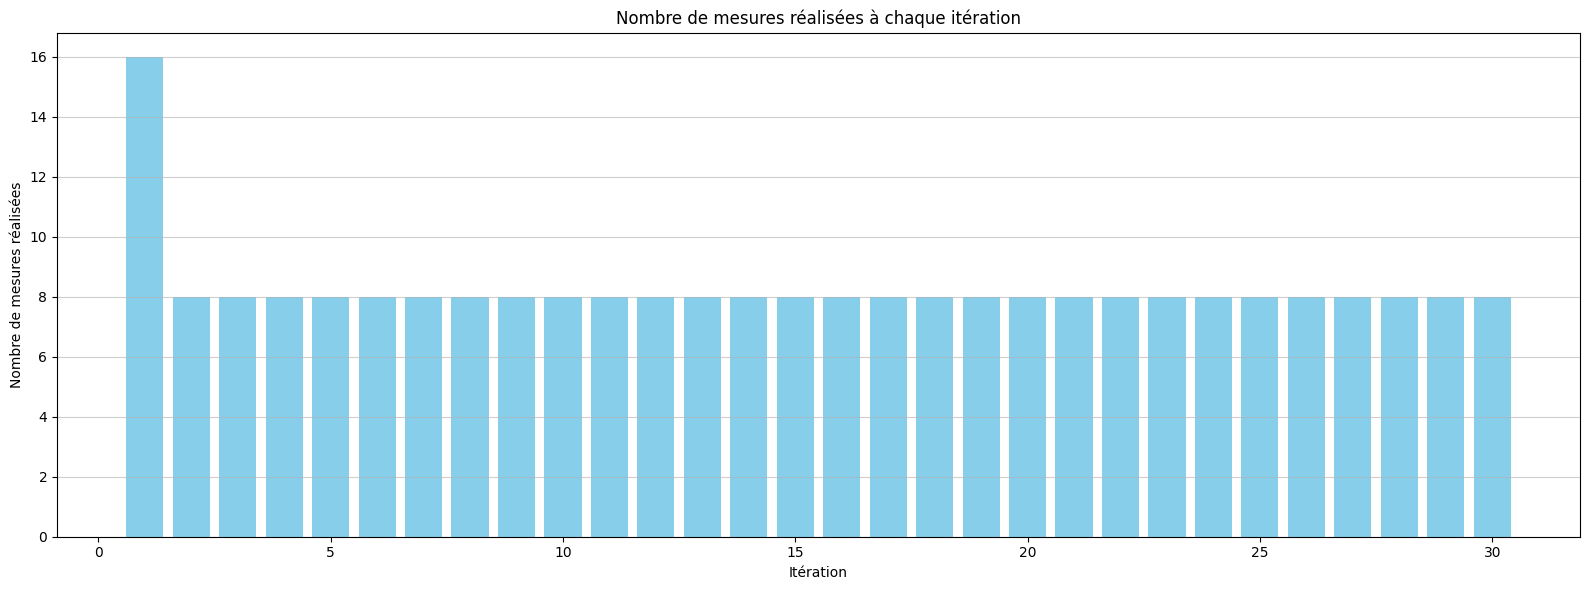

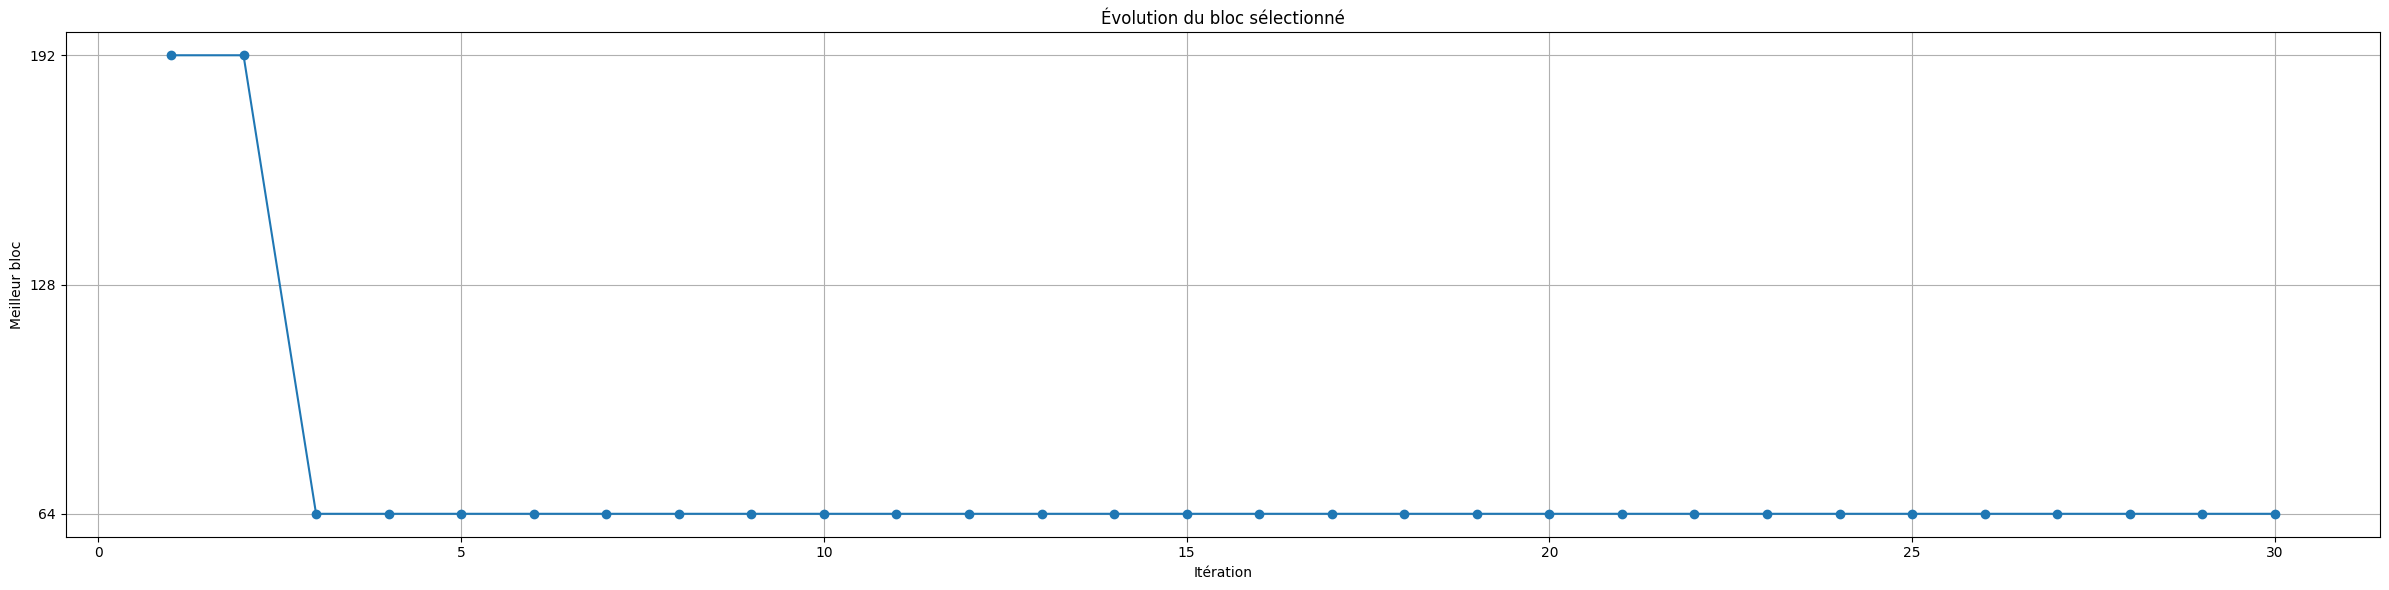

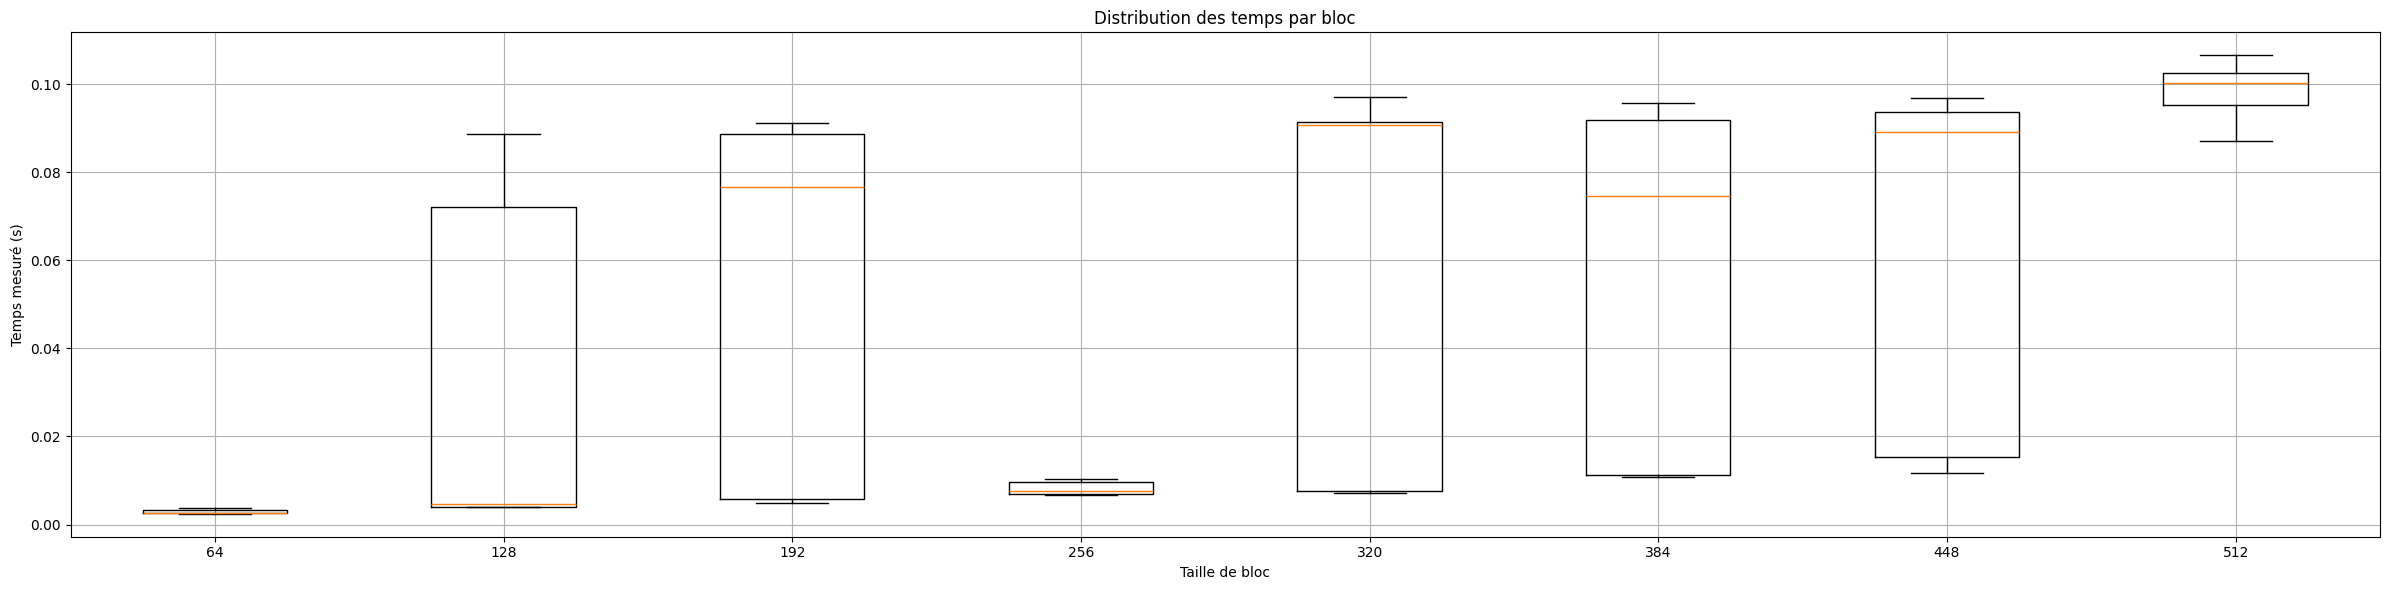

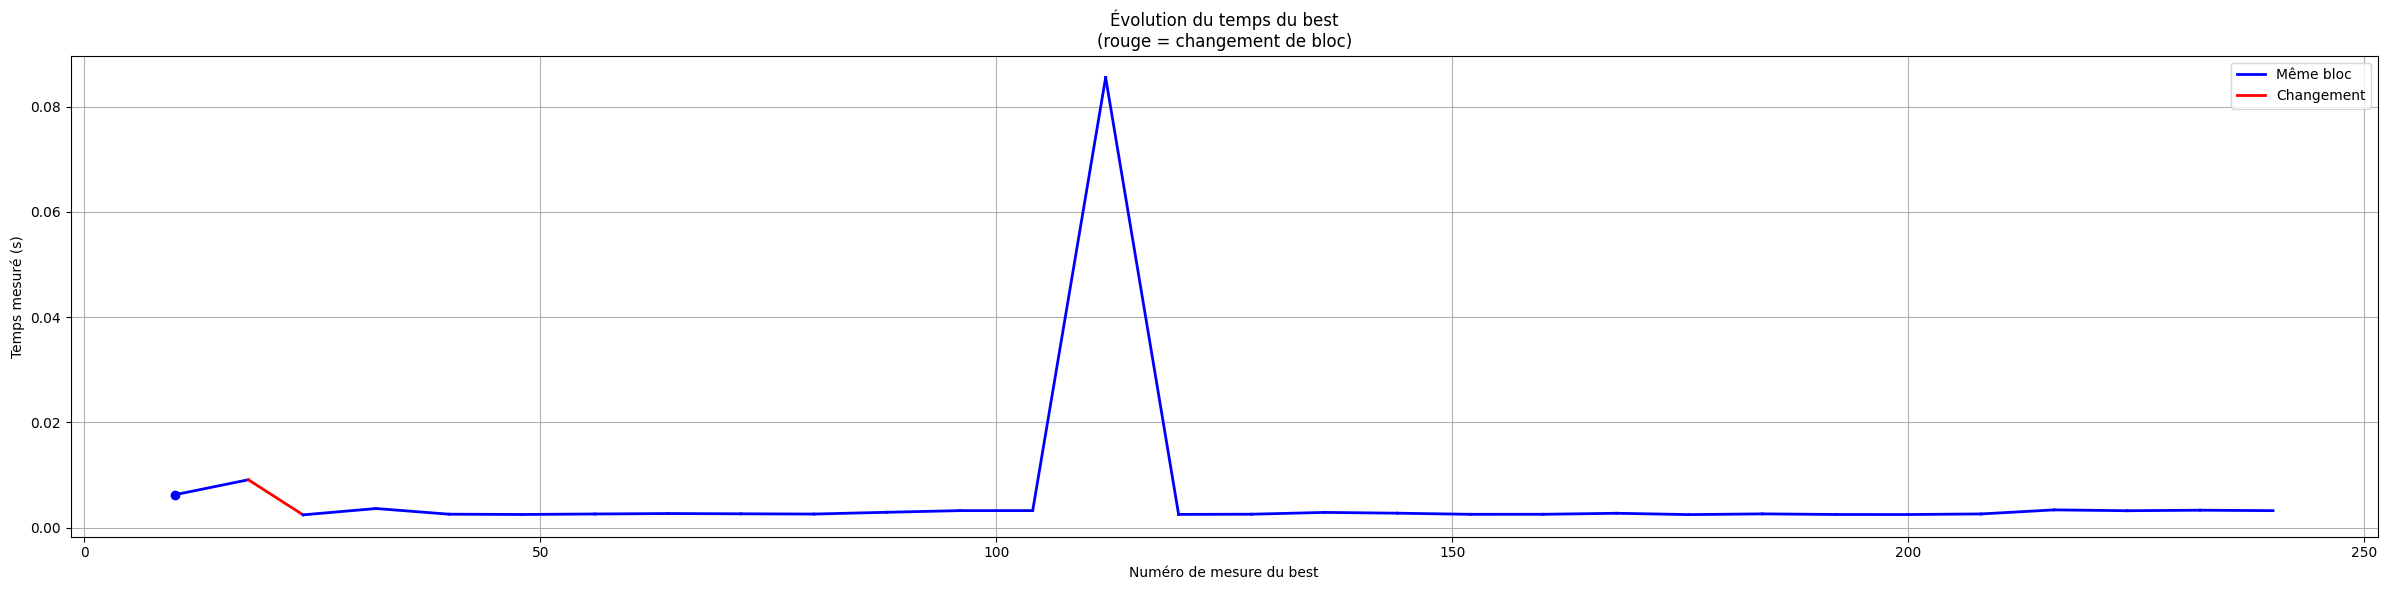

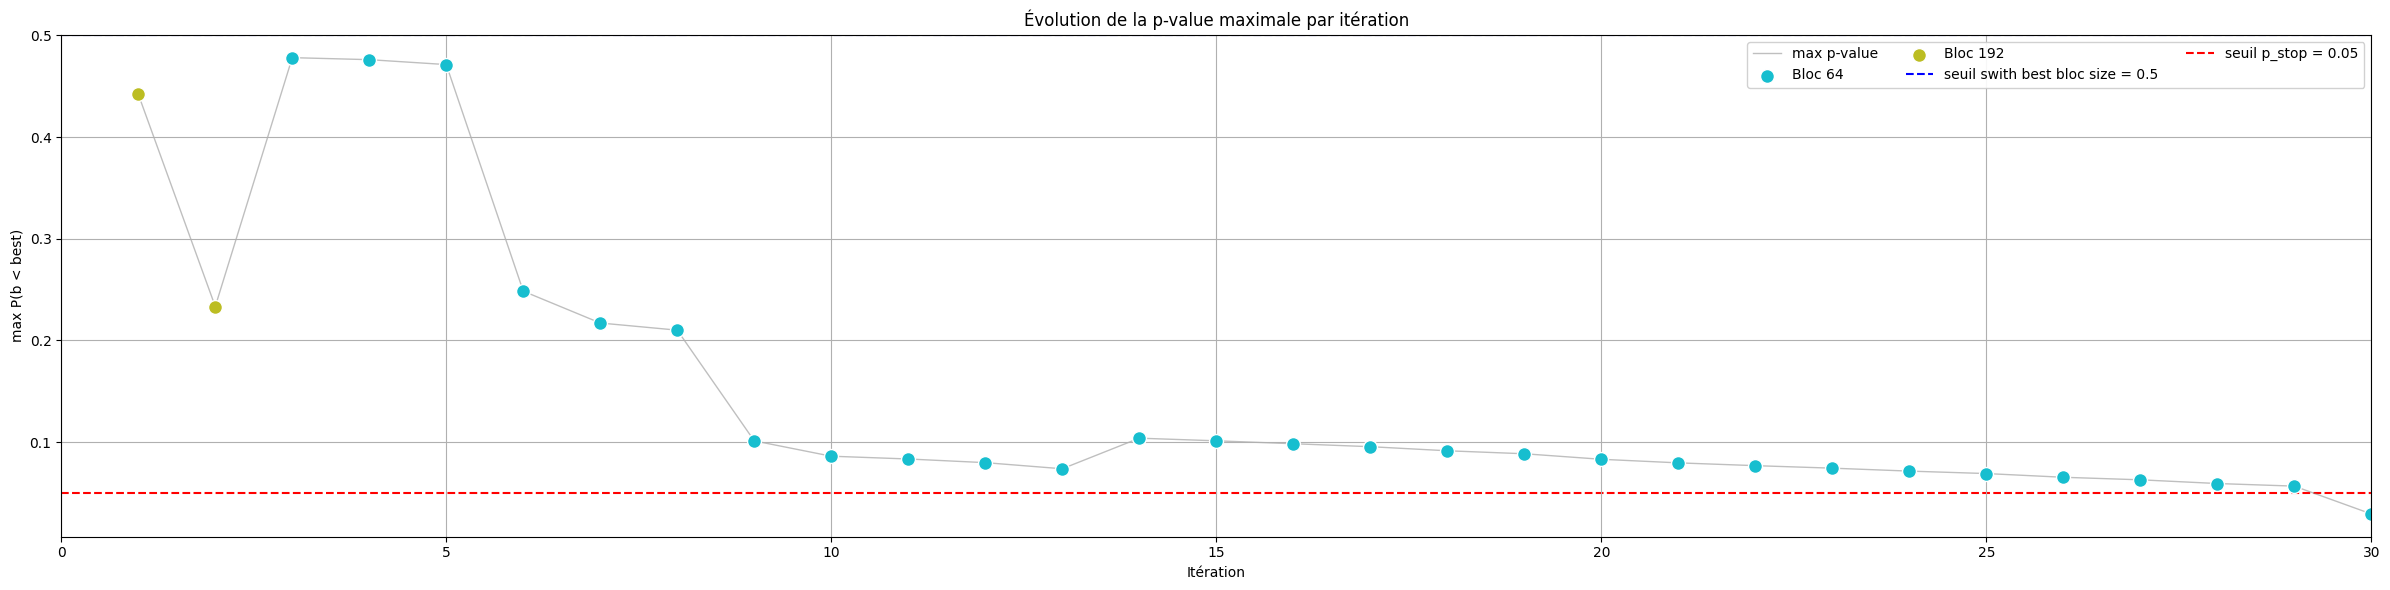

In [7]:
from graphique import plot_all_graphs

plot_dict_grille = {
    'best_track': result_grille['best_track'],
    'best_measurements': result_grille['best_measurements'],
    'results': result_grille['results'],
    'measure_per_iter': result_grille['measure_per_iter'],
    'p_history': result_grille['p_history'],
}

plot_all_graphs(
    blocks,
    **plot_dict_grille,
    p_switch=0.5,
    figsize=(24, 6),
    step=step,
)

## Meilleur Benchmark

In [8]:
from benchmark import smart_benchmark_probabilistic


result_adaptatif_benchmark = \
    smart_benchmark_probabilistic(
        x, blocks,
        extra_initial_repeats=0,
        free_runs=20,
        confidence=0.95,
        max_iter=1000,
        extra_repeats_best=0,
        verbose=verbose
    )


🏁 Best final : 64 (médiane=0.00319 s), mesures=102


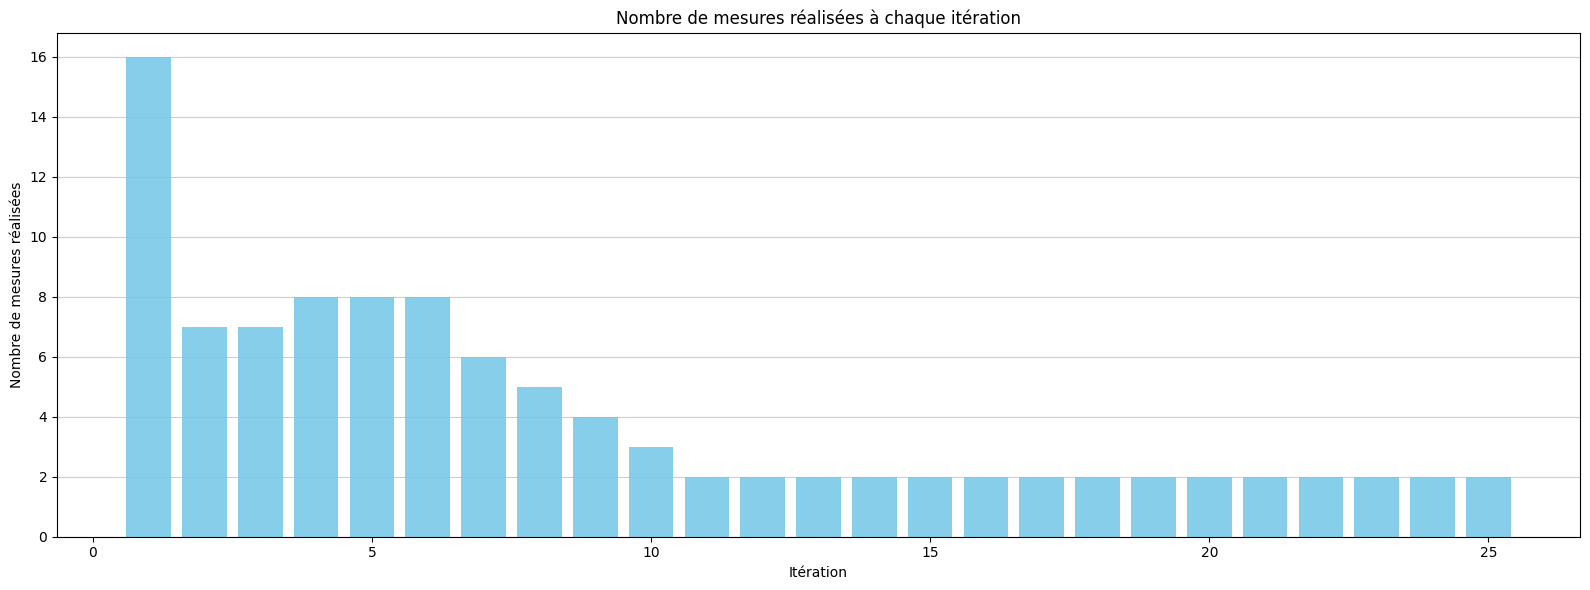

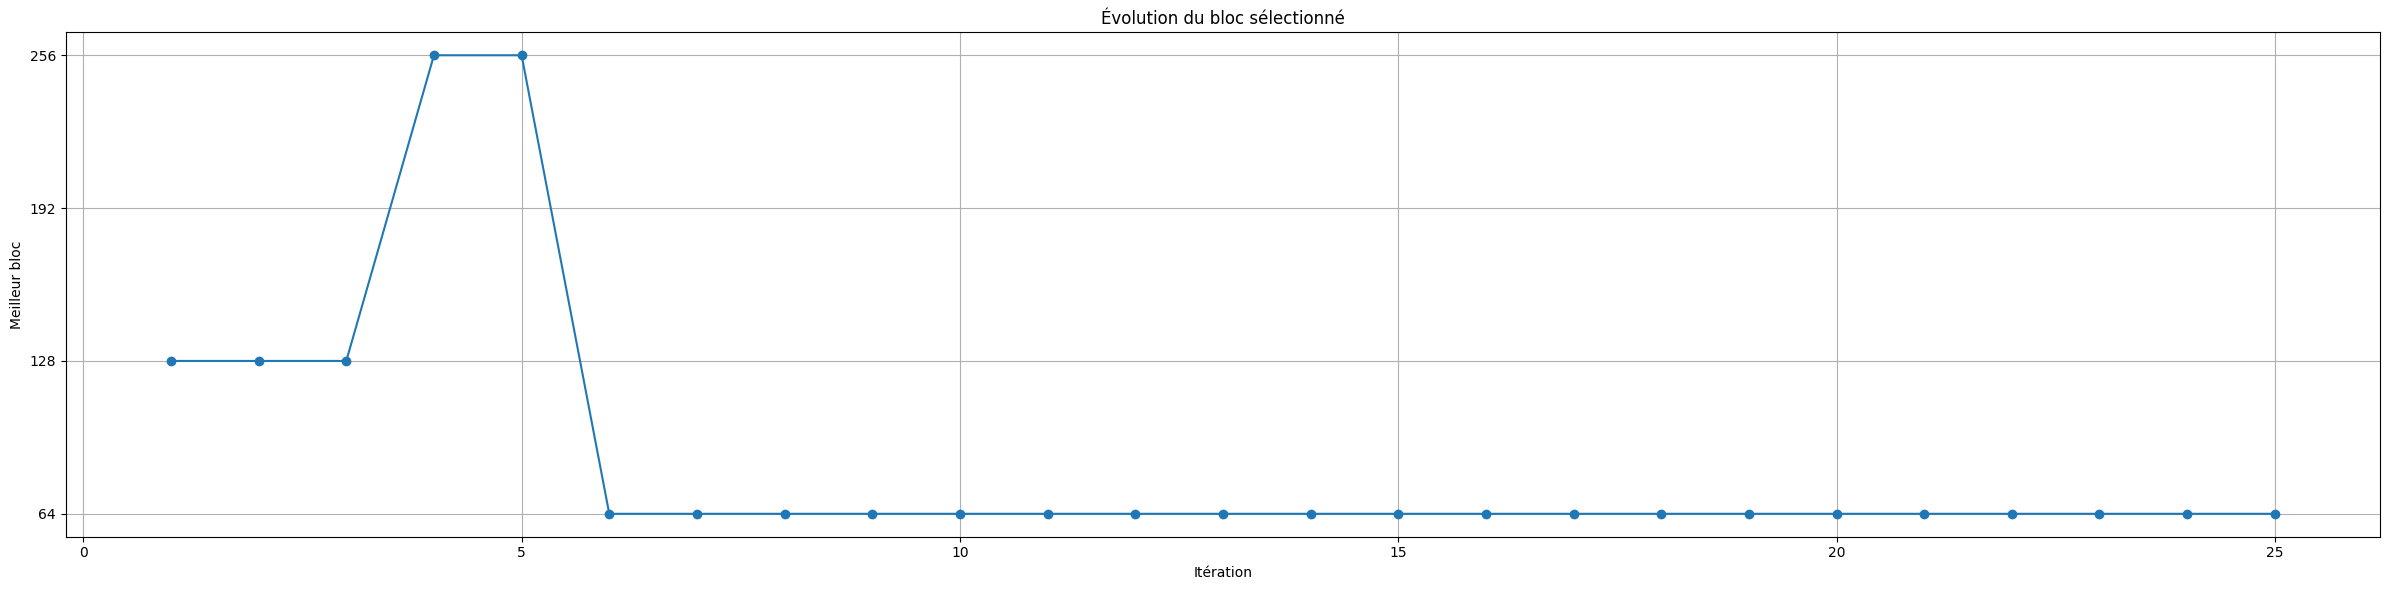

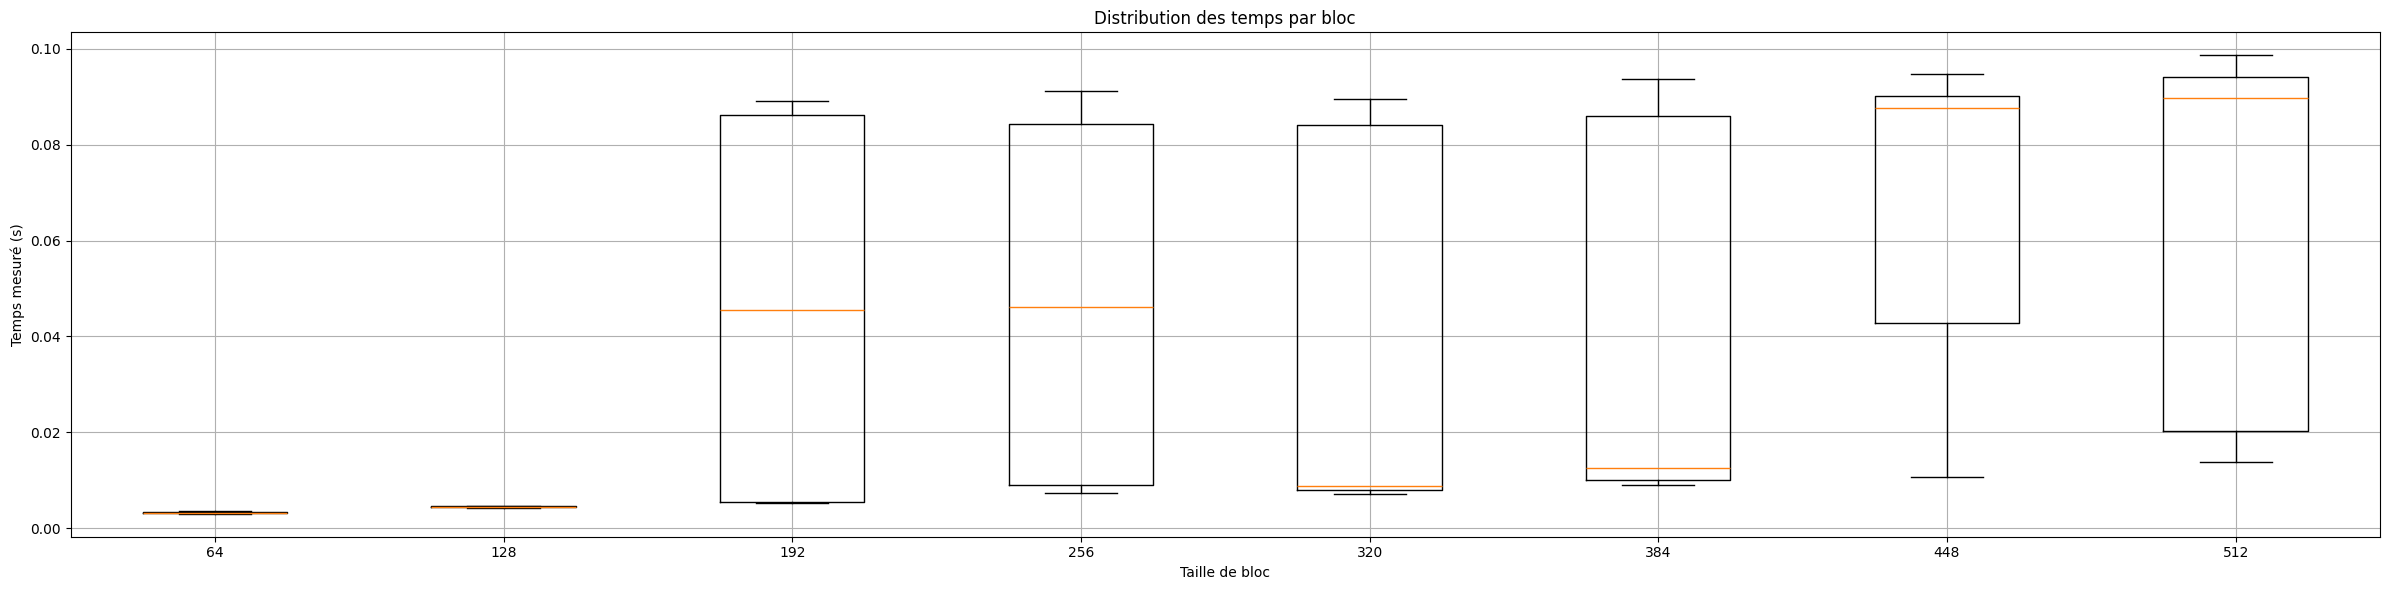

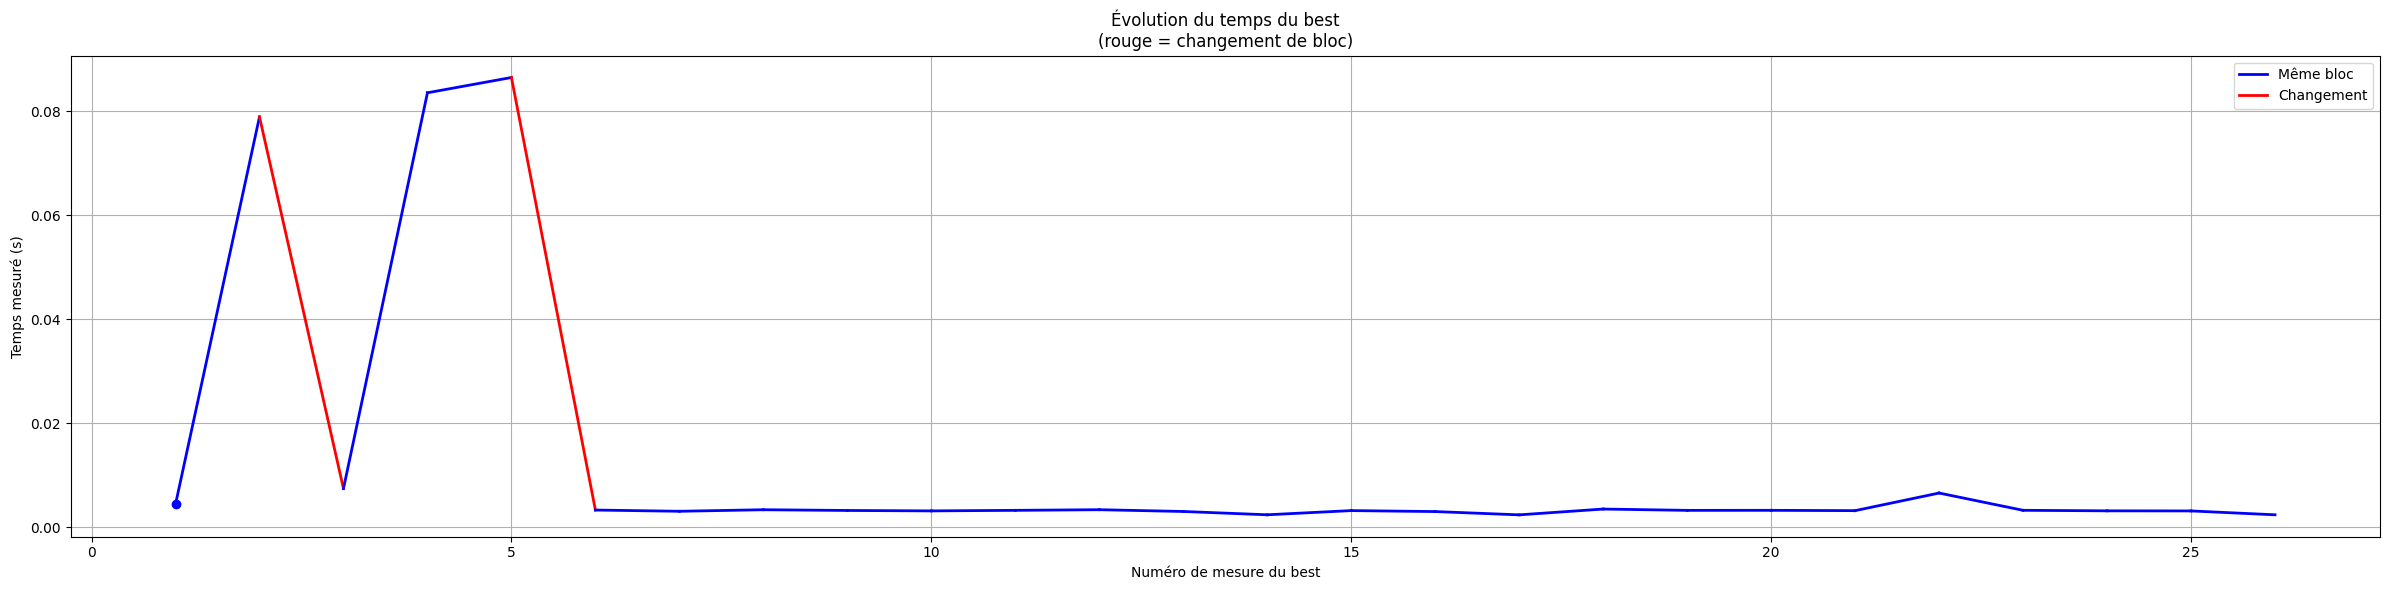

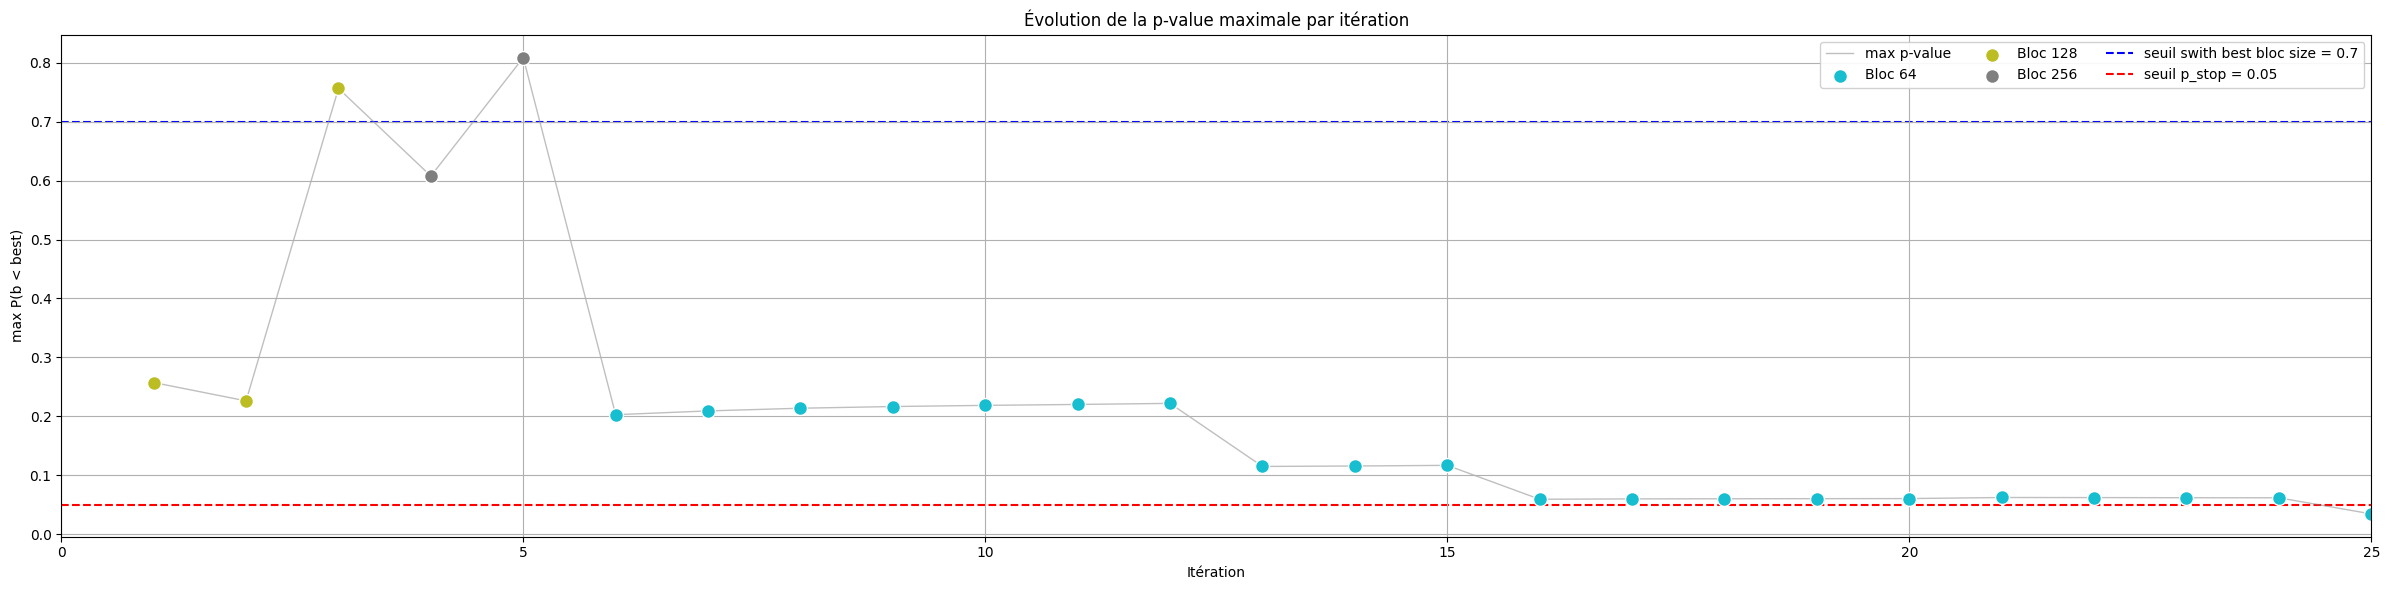

In [9]:
from graphique import plot_all_graphs

plot_dict_adaptatif_benchmark = {
    'best_track':           result_adaptatif_benchmark['best_track'],
    'best_measurements':    result_adaptatif_benchmark['best_measurements'],
    'results':              result_adaptatif_benchmark['results'],
    'measure_per_iter':     result_adaptatif_benchmark['measure_per_iter'],
    'p_history':            result_adaptatif_benchmark['p_history'],
}

plot_all_graphs(
    blocks,
    **plot_dict_adaptatif_benchmark,
    step=step,
    figsize=(24, 6),
    p_switch=0.7
)

## On compare l'evolution des p_value pour les 2 méthodes benchamrks (grille et adaptatif)

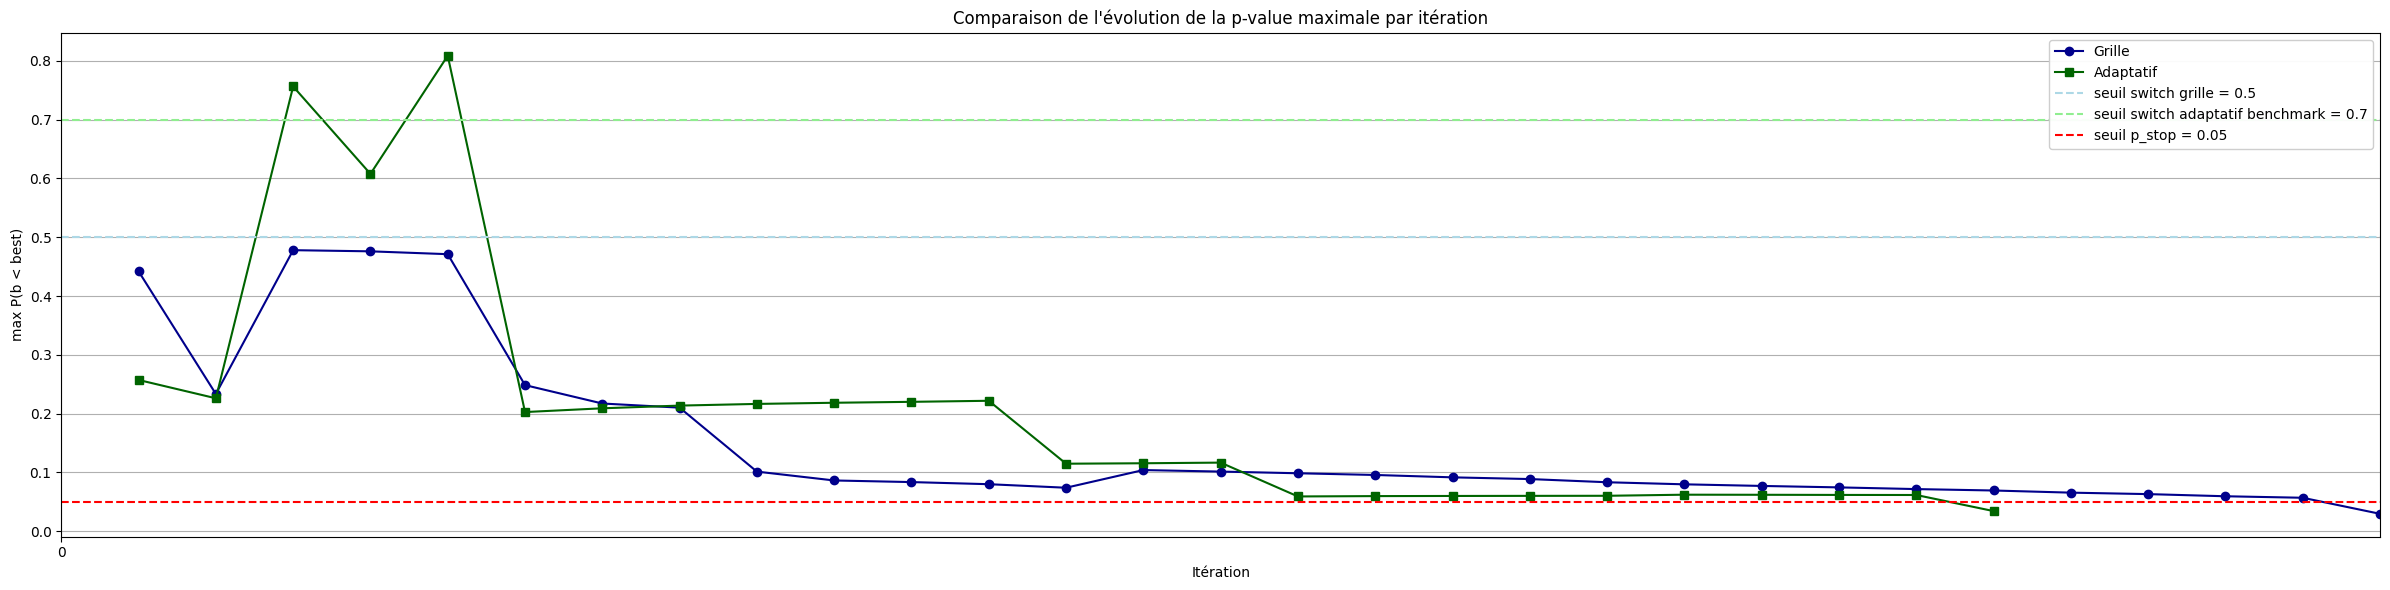

In [10]:
from graphique import compare_pvalue_evolution

compare_pvalue_evolution(
    result_grille['best_track'], result_grille['p_history'], 'Grille',
    result_adaptatif_benchmark['best_track'], result_adaptatif_benchmark['p_history'], 'Adaptatif',
    step=step,
    figsize=(24, 6)
)




# On test 20 fois le méthode grille VS le benchmark adaptatif pour comparer les 2 méthodes entre elles

In [11]:
N_REPEATS = 20

iterations_grille = []
mesures_grille = []
best_bloc_grille = []

iteration_smartB = []
mesures_smartB = []
best_bloc_smartB = []

for i in range(N_REPEATS):  
    # On change de matrice à chaque iteration
    x = np.random.randn(seq_len, d_model)

    # Grille exhaustive
    result_grille = exhaustive_grid_until_confidence(
        x, blocks, extra_initial_repeats=0, free_runs=2, confidence=0.95, max_iter=1_000, verbose=False
    )
    n_iterations_grille = len(result_grille['best_track'])
    n_mesures_grille = result_grille['measure_per_iter'][-1] if result_grille['measure_per_iter'] else 0
    best_block_g = result_grille['best']  # <---- récupère le best trouvé

    iterations_grille.append(n_iterations_grille)
    mesures_grille.append(n_mesures_grille)
    best_bloc_grille.append(best_block_g)

    # Smart benchmark
    result_smartB = smart_benchmark_probabilistic(
        x, blocks, extra_initial_repeats=0, free_runs=2, confidence=0.95, max_iter=1_000, p_switch=0.70, verbose=False
    )
    n_iterations_smart_bench = len(result_smartB['best_track'])
    n_mesures_smart_bench = result_smartB['measure_per_iter'][-1] if result_smartB['measure_per_iter'] else 0
    best_block_s = result_smartB['best']  # <---- récupère le best trouvé

    iteration_smartB.append(n_iterations_smart_bench)
    mesures_smartB.append(n_mesures_smart_bench)
    best_bloc_smartB.append(best_block_s)

    if verbose: 
        print(f"Test {i+1} terminé pour les 2 benchmark (grille et adaptatif)")



✅ Confiance 95% atteinte pour le meilleur bloc.

✅ Résultat final : Bloc 64, tests totaux = 64

🏁 Best final : 64 (médiane=0.00254 s), mesures=35

✅ Confiance 95% atteinte pour le meilleur bloc.

✅ Résultat final : Bloc 64, tests totaux = 208

🏁 Best final : 64 (médiane=0.00241 s), mesures=769

✅ Confiance 95% atteinte pour le meilleur bloc.

✅ Résultat final : Bloc 64, tests totaux = 136

🏁 Best final : 64 (médiane=0.00246 s), mesures=225

✅ Confiance 95% atteinte pour le meilleur bloc.

✅ Résultat final : Bloc 64, tests totaux = 160

🏁 Best final : 64 (médiane=0.00314 s), mesures=387

✅ Confiance 95% atteinte pour le meilleur bloc.

✅ Résultat final : Bloc 128, tests totaux = 72

🏁 Best final : 64 (médiane=0.00320 s), mesures=42

✅ Confiance 95% atteinte pour le meilleur bloc.

✅ Résultat final : Bloc 64, tests totaux = 184

🏁 Best final : 64 (médiane=0.00301 s), mesures=295

✅ Confiance 95% atteinte pour le meilleur bloc.

✅ Résultat final : Bloc 64, tests totaux = 808

🏁 Best fina

In [12]:
# --- Construction du tableau final ---
df = pd.DataFrame({
    "best_bloc_grille": best_bloc_grille,
    "best_bloc_adaptatif": best_bloc_smartB
})
df["meme_resultat"] = df["best_bloc_grille"] == df["best_bloc_adaptatif"]

print(df)

    best_bloc_grille  best_bloc_adaptatif  meme_resultat
0                 64                   64           True
1                 64                   64           True
2                 64                   64           True
3                 64                   64           True
4                128                   64          False
5                 64                   64           True
6                 64                   64           True
7                 64                   64           True
8                 64                   64           True
9                 64                   64           True
10                64                   64           True
11                64                   64           True
12                64                   64           True
13                64                   64           True
14                64                   64           True
15                64                   64           True
16                64           

=== Résumé sur 20 lancements ===
Grille exhaustive   : 33.5 itérations, 275.6 mesures en moyenne
Benchmark adaptatif : 69.6 itérations, 206.8 mesures en moyenne


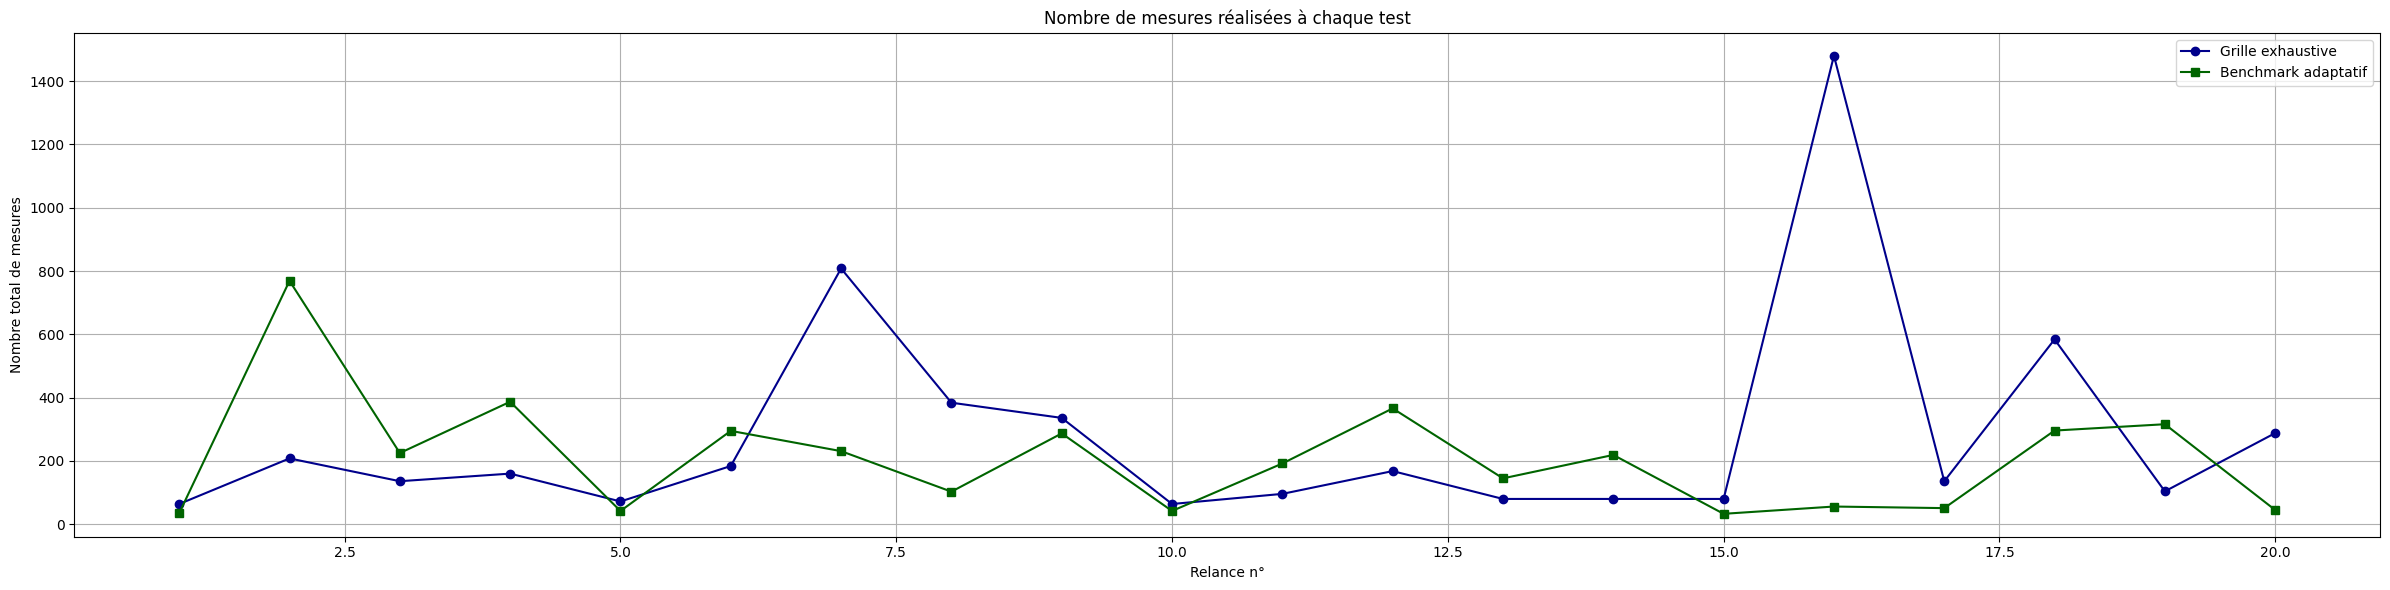

In [13]:
# Affichage des moyennes
print("=== Résumé sur", N_REPEATS, "lancements ===")
print(f"Grille exhaustive   : {np.mean(iterations_grille):.1f} itérations, {np.mean(mesures_grille):.1f} mesures en moyenne")
print(f"Benchmark adaptatif : {np.mean(iteration_smartB):.1f} itérations, {np.mean(mesures_smartB):.1f} mesures en moyenne")

# Graphique des mesures réalisées à chaque test
plt.figure(figsize=(24, 6))
plt.plot(range(1, N_REPEATS+1), mesures_grille, marker='o', color='darkblue', label="Grille exhaustive")
plt.plot(range(1, N_REPEATS+1), mesures_smartB, marker='s', color='darkgreen', label="Benchmark adaptatif")
plt.xlabel("Relance n°")
plt.ylabel("Nombre total de mesures")
plt.title("Nombre de mesures réalisées à chaque test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()